# Surface flux transport (SFT) simulation Notebook

 Soumyaranjan Dash | National Solar Observatory

----

**About this notebook:**

- This notebook shows example SFT simulation for solar surface. 
- Flux transport is driven by prescribed solar meridional (pole-ward flow) flow and differential rotation.
- An initial global dipolar field is evolved here without any sun/star spots.
  
----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import rc
import matplotlib.style
try: 
    plt.rcParams["font.family"] = 'DejaVu Serif'
except: 
    print(' Arial font not available - using default')
plt.rcParams.update({
    "font.size": 10,  # Default font size for all text
    "axes.labelsize": 10,  # Font size for x and y labels
    "xtick.labelsize": 10,  # Font size for x-axis ticks
    "ytick.labelsize": 10,  # Font size for y-axis ticks
    "legend.fontsize": 10  # Font size for legends
})

### Import sft2d package and check teh latest version.
- For installing the package you can run
```
  pip install git+https://github.com/sr-dash/SFT2D.git sft2d
```

In [1]:
import sft2d
print(sft2d.__version__)

ModuleNotFoundError: No module named 'sft2d'

In [7]:
import sys
print(sys.executable)
!{sys.executable} -m pip show sft2d

/home/sdash/miniforge3/envs/pycelp/bin/python3.13
Name: sft2d
Version: 0.0.5.post2
Summary: 2D Surface Flux Transport (SFT) simulation and analysis package.
Home-page: https://github.com/sr-dash/sft2d
Author: Soumyaranjan Dash
Author-email: Soumyaranjan Dash <dash.soumya922@gmail.com>
License: <<<<<<< HEAD
<<<<<<< HEAD
>>>>>>> 7bec2f1157c4643fc5ef5e230214bc6b160f77bf
MIT License

Copyright (c) 2025 Soumyaranjan Dash

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS P

In [6]:
!pip list | grep sft2d

sft2d                     0.0.5.post2


In [4]:
# pip install --no-cache-dir git+https://github.com/sr-dash/SFT2D.git

In [15]:
from sft2d import create_grid, initialize_field, meridional_flow, differential_rotation, calculate_time_step, calculate_diffusion, calculate_advection,calculate_polar_flux
from sft2d import calculate_usflx, calculate_dm, calculate_polar_field, plot_bfly, plot_mag


## Initial model setup
- Setup the grid resolution
- Model the pre-defined meridional flow and differential rotation of the grid.
- Initialize the global dipole on the gird.
- Set the magnetic diffusivity.
- Compute the global timestep based on grid resolution, flows and diffusivity.

In [6]:
grid_sft = create_grid(180,360)
mf_ = meridional_flow(grid_sft.copy())
dr_ = differential_rotation(grid_sft.copy(),rotation='solar',frame='carrington')
field = initialize_field(grid_sft.copy(), 'dipole')
diffusivity = 2.5 * 10**8 # cm^2/s
ts, ndt = calculate_time_step(grid_sft.copy(), diffusivity)

#### Initialise arrays for plotting.
- Import arrays from sft grid for plotting. 

In [7]:
colatitude = grid_sft['colatitude']
longitude = grid_sft['longitude']
delta_theta = grid_sft['dtheta']
delta_phi = grid_sft['dphi']
solar_radius = 6.955 * 10**8

#### Visualizing the initial dipole 

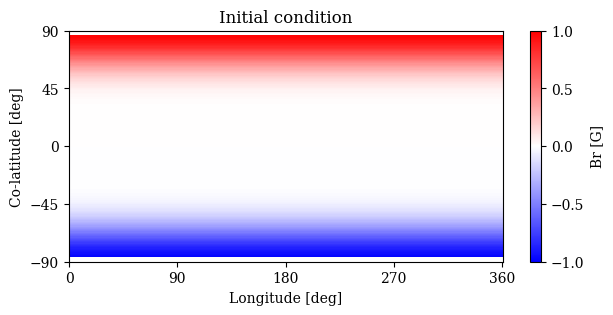

In [23]:
plt.figure(figsize=[7,3])
plt.pcolormesh(np.degrees(longitude),np.degrees(np.pi/2-colatitude),field,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(0,361,90))
plt.yticks(np.arange(-90,91,45))
plt.colorbar(label='Br [G]',ticks=np.arange(-1,1.1,0.5))
plt.title('Initial condition')
plt.xlabel('Longitude [deg]')
plt.ylabel('Co-latitude [deg]')
plt.show()

#### Visualizing the flow profiles.

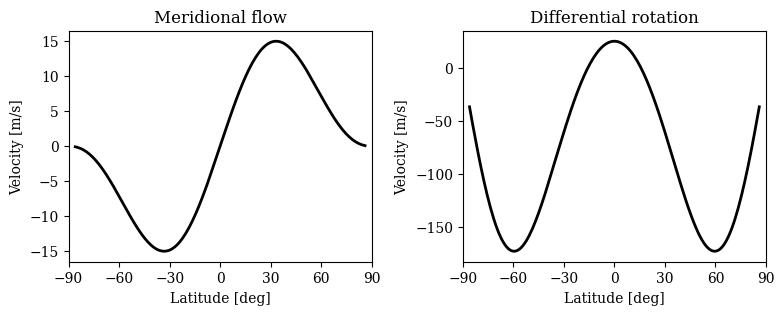

In [24]:
# plt.plot(sc,vph_om2[:,180])
plt.figure(figsize=[9,3])

ax1 = plt.subplot(121)
ax1.plot(np.rad2deg(np.pi/2-grid_sft['colatitude']),mf_[::-1,180],color='k',label='Meridional flow',lw=2)
ax1.set_xlabel('Latitude [deg]')
ax1.set_ylabel('Velocity [m/s]')
ax1.set_title('Meridional flow')
ax1.set_xlim([-90,90])
ax1.set_xticks(np.arange(-90,91,30))

ax2 = plt.subplot(122)
ax2.plot(np.rad2deg(np.pi/2-grid_sft['colatitude']),dr_[:,180]*np.sin(grid_sft['colatitude'])*solar_radius,c='k',label='Differential rotation',lw=2)
ax2.set_xlabel('Latitude [deg]')
ax2.set_ylabel('Velocity [m/s]')
ax2.set_title('Differential rotation')
ax2.set_xlim([-90,90])
ax2.set_xticks(np.arange(-90,91,30))

plt.subplots_adjust(wspace=0.3)

# plt.savefig('./docs/flows.png',dpi=300)

plt.show()

## Simulating flux transport process
- Evolution of surface magnetic flux distribution is driven by flows and diffusion only.
- Here we show the dynamics over 1 year.

In [69]:
num_days = 1*365  # Example total time steps
num_theta = grid_sft['colatitude'].size
num_phi = grid_sft['longitude'].size
bfly_data = np.zeros((num_days+1,num_theta))
all_br_data = np.zeros((num_days+1,num_theta,num_phi))
all_br_data[0,:,:] = -1*5*field.copy()/np.max(field.copy())
bfly_data[0,:] = np.mean(field,axis=1)

B_temp = -1*5*field.copy()/np.max(field.copy())
B_temp_update = np.zeros_like(field)

# Time loop for evolution
for t in tqdm(range(1,num_days+1),desc='Simulation days: '):
    delta_t = ts
    for steps in range(ndt):
        # Calculate the diffusion term
        B_temp_diff = calculate_diffusion(B_temp, diffusivity, grid_sft.copy())
        # Calculate the advection term
        B_temp_adv = calculate_advection(B_temp, dr_, mf_, grid_sft.copy())
        
        # Update magnetic field using all terms
        B_temp_update[1:-1, 1:-1] = B_temp[1:-1, 1:-1] + delta_t * (1.0*B_temp_diff - 1.0*B_temp_adv)

        # Apply periodic boundary conditions in the phi direction
        B_temp_update[:, 0] = B_temp_update[:, -2]  # First column matches second-to-last column
        B_temp_update[:, -1] = B_temp_update[:, 1]  # Last column matches second column

        # Apply open boundary conditions in the theta direction
        B_temp_update[0, :] = B_temp_update[1, :]    # Northern boundary (pole)
        B_temp_update[-1, :] = B_temp_update[-2, :]  # Southern boundary (pole)
        B_temp = B_temp_update.copy()
    # Save the butterfly diagram
    bfly_data[t,:] = np.mean(B_temp,axis=1)
    all_br_data[t,:,:] = B_temp.copy()
    

Simulation days: 100%|██████████| 365/365 [04:46<00:00,  1.27it/s]


## Some derived quantities for visualization

In [70]:
usflx = calculate_usflx(all_br_data, grid_sft.copy(), [0,num_days])
dm_sft = calculate_dm(all_br_data, grid_sft.copy(), [0,num_days])
polar_n, polar_s = calculate_polar_field(all_br_data, grid_sft.copy(), [0,num_days])
polar_fln, polar_fls = calculate_polar_flux(all_br_data, grid_sft.copy(), [0,num_days])

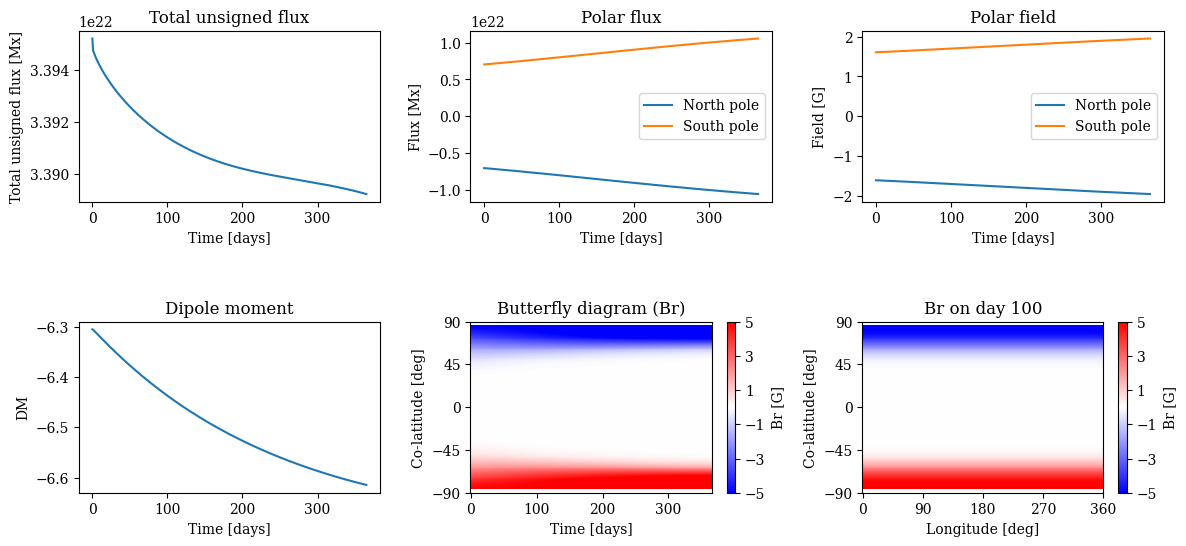

In [71]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.flatten()
ax[0].plot(np.arange(num_days+1),usflx)
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Total unsigned flux [Mx]')
ax[0].set_title('Total unsigned flux')

ax[1].plot(np.arange(num_days+1),polar_fln,label='North pole')
ax[1].plot(np.arange(num_days+1),polar_fls,label='South pole')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Flux [Mx]')
ax[1].set_title('Polar flux')
ax[1].legend()

ax[2].plot(np.arange(num_days+1),polar_n,label='North pole')
ax[2].plot(np.arange(num_days+1),polar_s,label='South pole')
ax[2].set_xlabel('Time [days]')
ax[2].set_ylabel('Field [G]')
ax[2].set_title('Polar field')
ax[2].legend()

ax[3].plot(np.arange(num_days+1),dm_sft,label='North pole')
ax[3].set_xlabel('Time [days]')
ax[3].set_ylabel('DM')
ax[3].set_title('Dipole moment')

pm1 = ax[4].pcolormesh(np.arange(num_days+1),np.degrees(np.pi/2-colatitude),bfly_data.T,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(pm1, label='Br [G]',ticks=np.arange(-5,5.1,2))
ax[4].set_yticks(np.arange(-90,91,45))
ax[4].set_title('Butterfly diagram (Br)')
ax[4].set_xlabel('Time [days]')
ax[4].set_ylabel('Co-latitude [deg]')

idx = 100
pm2 = ax[5].pcolormesh(np.degrees(longitude),np.degrees(np.pi/2-colatitude),all_br_data[idx,:,:],cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(pm2, label='Br [G]',ticks=np.arange(-5,5.1,2))
ax[5].set_yticks(np.arange(-90,91,45))
ax[5].set_xticks(np.arange(0,361,90))
ax[5].set_title(f'Br on day {idx:03d}')
ax[5].set_xlabel('Longitude [deg]')
ax[5].set_ylabel('Co-latitude [deg]')

plt.subplots_adjust(hspace=0.7,wspace=0.3)
plt.show()

## Bipolar Magnetic Region (BMR) modelling
- BMRs or Active regions (ARs) are often observed on the surface of the star. Transport of this emerged flux has to be incorporated into SFT model as source terms.
- There can be different ways to model a BMR. Or one can choose to directly assimilate magnetic field distribution from observations for the Sun.

In [53]:
def inject_bipole_flux_normalized(theta, phi, lat, lon, flux_Mx, tilt_deg, sep_deg,
    sigma_deg=4.0, Rsun_cm=6.96e10, apply_hale=True):
    """
    Injects a bipole with correct Joy's law tilt: defined as angle from local E-W (latitude) line.
    """

    import numpy as np

    # --- Mesh and area elements ---
    theta_2d, phi_2d = np.meshgrid(theta, phi, indexing='ij')
    dtheta = theta[1] - theta[0]
    dphi = phi[1] - phi[0]
    dA = Rsun_cm**2 * np.sin(theta_2d) * dtheta * dphi

    # --- Convert center location ---
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon) % (2*np.pi)
    colat_rad = np.radians(90 - lat)

    # --- Tilt angle and separation ---
    tilt_rad = np.radians(tilt_deg)
    sep_rad = np.radians(sep_deg / 2)
    sigma_rad = np.radians(sigma_deg)

    # --- Unit vector at center (on unit sphere) ---
    x0 = np.cos(lat_rad) * np.cos(lon_rad)
    y0 = np.cos(lat_rad) * np.sin(lon_rad)
    z0 = np.sin(lat_rad)
    r0 = np.array([x0, y0, z0])

    # --- Define local tangent basis vectors at r0 ---
    # e_phi: east direction
    e_phi = np.array([-np.sin(lon_rad), np.cos(lon_rad), 0.0])
    # e_theta: south direction (increasing theta)
    e_theta = np.array([
        -np.sin(lat_rad)*np.cos(lon_rad),
        -np.sin(lat_rad)*np.sin(lon_rad),
        np.cos(lat_rad)
    ])
    # e_lat: north direction (decreasing theta)
    e_lat = -e_theta

    # --- Separation vector in tangent plane ---
    # Tilt is measured from e_phi (east) toward north (positive lat direction)
    # So: sep_vec = cos(tilt) * east + sin(tilt) * north
    sep_vec = np.cos(tilt_rad) * e_phi + np.sin(tilt_rad) * e_lat

    # --- Polarity centers on sphere ---
    lead_vec = r0 + sep_rad * sep_vec
    foll_vec = r0 - sep_rad * sep_vec

    def vec_to_sph(v):
        """Convert 3D vector to (theta, phi)"""
        r = np.linalg.norm(v)
        theta = np.arccos(v[2] / r)     # colatitude
        phi = np.arctan2(v[1], v[0]) % (2*np.pi)
        return theta, phi

    th_lead, ph_lead = vec_to_sph(lead_vec)
    th_foll, ph_foll = vec_to_sph(foll_vec)

    # --- Determine polarity signs from Hale's Law ---
    if apply_hale:
        if lat >= 0:  # Northern hemisphere
            sign_lead = +1
            sign_foll = -1
        else:
            sign_lead = -1
            sign_foll = +1
    else:
        sign_lead = +1
        sign_foll = -1

    # --- Angular distance handling ---
    def phi_dist(p1, p2):
        return np.minimum(np.abs(p1 - p2), 2*np.pi - np.abs(p1 - p2))

    def gaussian(th_c, ph_c, sign):
        dth2 = (theta_2d - th_c)**2
        dph2 = phi_dist(phi_2d, ph_c)**2
        return sign * np.exp(- (dth2 + dph2) / (2 * sigma_rad**2))

    # --- Compute raw B field pattern ---
    B_unit = (
        gaussian(th_lead, ph_lead, sign_lead) +
        gaussian(th_foll, ph_foll, sign_foll)
    )

    flux_unit = np.sum(np.abs(B_unit) * dA)
    scale = flux_Mx / flux_unit
    B_scaled = scale * B_unit
    return B_scaled


### Load BMR property for a solar cycle for a test run
- This is a test run to check the performance of SFT simulation.
- We are not caliberating the SFT obtained fluxes to the observations here. This can be done by changing initial condition, BMR properties, flow parameters.

In [51]:
import pandas as pd
sc14 = np.loadtxt('/data/sdash/SFT2D/test_data/SC_14.txt')
sc15 = np.loadtxt('/data/sdash/SFT2D/test_data/SC_15.txt')

sc14_df = pd.DataFrame(sc14, columns=['Phase', 'Latitude', 'Tilt', 'Radius', 'Longitude', 'USFLUX'])
sc15_df = pd.DataFrame(sc15[1:,], columns=['Phase', 'Latitude', 'Tilt', 'Radius', 'Longitude', 'USFLUX'])

In [66]:
# initial_field = sc14_all_br[-1,:,:]

num_days =  int(120*28)  # Example total time steps
num_theta = grid_sft['colatitude'].size
num_phi = grid_sft['longitude'].size
bfly_data = np.zeros((num_days+1,num_theta))
all_br_data = np.zeros((num_days+1,num_theta,num_phi))
# all_br_data[0,:,:] = initial_field #-1*10*field.copy()/np.max(field.copy())
all_br_data[0,:,:] = -1*10*field.copy()/np.max(field.copy())
bfly_data[0,:] = np.mean(field,axis=1)

# B_temp = initial_field #-1*10*field.copy()/np.max(field.copy())
B_temp = -1*10*field.copy()/np.max(field.copy())
B_temp_update = np.zeros_like(field)

n_cr = 1.0

# Time loop for evolution
for t in tqdm(range(1,num_days+1),desc='Simulation days: '):
    delta_t = ts
    # Add the sunspots from sc14_df dataframe when the time step divisble by 28 is equal to the current phase.
    if t % 28 == 0:
        n_cr = t // 28
        for index, row in sc14_df[sc14_df['Phase'] == n_cr].iterrows():
            Br_spot = inject_bipole_flux_normalized(grid_sft.copy()['colatitude'], grid_sft.copy()['longitude'],
                                            lat=row['Latitude'], lon=row['Longitude'],flux_Mx=-1.0*float(row['USFLUX'])*1e16, 
                                            tilt_deg=float(row['Tilt']), sep_deg=1.0*float(row['Radius']), sigma_deg=2.0, apply_hale=True)
            B_temp += Br_spot
    for steps in range(ndt):
        # Calculate the diffusion term
        B_temp_diff = calculate_diffusion(B_temp, diffusivity, grid_sft.copy())
        # Calculate the advection term
        B_temp_adv = calculate_advection(B_temp, dr_, mf_, grid_sft.copy())
        
        # Update magnetic field using all terms
        B_temp_update[1:-1, 1:-1] = B_temp[1:-1, 1:-1] + delta_t * (1.0*B_temp_diff - 1.0*B_temp_adv)

        # Apply periodic boundary conditions in the phi direction
        B_temp_update[:, 0] = B_temp_update[:, -2]  # First column matches second-to-last column
        B_temp_update[:, -1] = B_temp_update[:, 1]  # Last column matches second column

        # Apply open boundary conditions in the theta direction
        B_temp_update[0, :] = B_temp_update[1, :]    # Northern boundary (pole)
        B_temp_update[-1, :] = B_temp_update[-2, :]  # Southern boundary (pole)
        B_temp = B_temp_update.copy()
    # Save the butterfly diagram
    bfly_data[t,:] = np.mean(B_temp,axis=1)
    all_br_data[t,:,:] = B_temp.copy()
    

Simulation days: 100%|██████████| 3360/3360 [57:34<00:00,  1.03s/it] 


### Compute and plot the solar cycle parameters

In [67]:
usflx = calculate_usflx(all_br_data, grid_sft.copy(), [0,num_days])
dm_sft = calculate_dm(all_br_data, grid_sft.copy(), [0,num_days])
polar_n, polar_s = calculate_polar_field(all_br_data, grid_sft.copy(), [0,num_days])
polar_fln, polar_fls = calculate_polar_flux(all_br_data, grid_sft.copy(), [0,num_days])

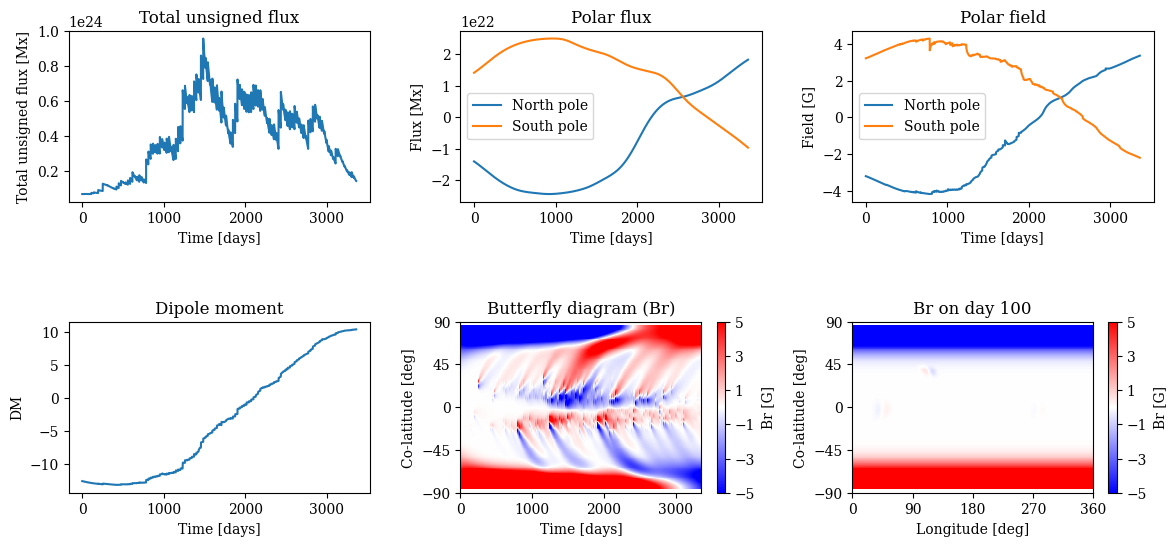

In [68]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.flatten()
ax[0].plot(np.arange(num_days+1),usflx)
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Total unsigned flux [Mx]')
ax[0].set_title('Total unsigned flux')

ax[1].plot(np.arange(num_days+1),polar_fln,label='North pole')
ax[1].plot(np.arange(num_days+1),polar_fls,label='South pole')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Flux [Mx]')
ax[1].set_title('Polar flux')
ax[1].legend()

ax[2].plot(np.arange(num_days+1),polar_n,label='North pole')
ax[2].plot(np.arange(num_days+1),polar_s,label='South pole')
ax[2].set_xlabel('Time [days]')
ax[2].set_ylabel('Field [G]')
ax[2].set_title('Polar field')
ax[2].legend()

ax[3].plot(np.arange(num_days+1),dm_sft,label='North pole')
ax[3].set_xlabel('Time [days]')
ax[3].set_ylabel('DM')
ax[3].set_title('Dipole moment')

pm1 = ax[4].pcolormesh(np.arange(num_days+1),np.degrees(np.pi/2-colatitude),bfly_data.T,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(pm1, label='Br [G]',ticks=np.arange(-5,5.1,2))
ax[4].set_yticks(np.arange(-90,91,45))
ax[4].set_title('Butterfly diagram (Br)')
ax[4].set_xlabel('Time [days]')
ax[4].set_ylabel('Co-latitude [deg]')

idx = 100
pm2 = ax[5].pcolormesh(np.degrees(longitude),np.degrees(np.pi/2-colatitude),all_br_data[idx,:,:],cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(pm2, label='Br [G]',ticks=np.arange(-5,5.1,2))
ax[5].set_yticks(np.arange(-90,91,45))
ax[5].set_xticks(np.arange(0,361,90))
ax[5].set_title(f'Br on day {idx:03d}')
ax[5].set_xlabel('Longitude [deg]')
ax[5].set_ylabel('Co-latitude [deg]')

plt.subplots_adjust(hspace=0.7,wspace=0.3)
plt.show()

#### Visualization of a sinlge BMR

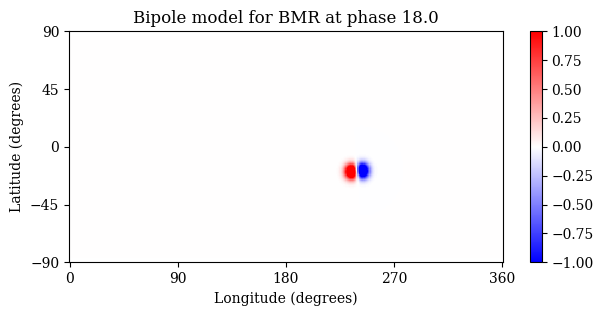

In [65]:
idx = 40
latitude1 = sc14_df['Latitude'].iloc[idx]
longitude1 = sc14_df['Longitude'].iloc[idx]
usflux1 = float(sc14_df['USFLUX'].iloc[idx])
radius1 = sc14_df['Radius'].iloc[idx]
tilt1 = sc14_df['Tilt'].iloc[idx]
Br1 = np.zeros((grid_sft['colatitude'].size, grid_sft['longitude'].size))
Br1 = inject_bipole_flux_normalized(grid_sft.copy()['colatitude'], grid_sft.copy()['longitude'],
                                        lat=latitude1, lon=longitude1,flux_Mx=usflux1*1e16, 
                                        tilt_deg=tilt1, sep_deg=3*radius1, apply_hale=True)
plt.figure(figsize=[7,3])
plt.pcolormesh(np.rad2deg(grid_sft.copy()['longitude']),90 - np.rad2deg(grid_sft.copy()['colatitude']),Br1,cmap='bwr',vmin=-1,vmax=1)
plt.colorbar()
plt.yticks(np.arange(-90,91,45))
plt.xticks(np.arange(0,361,90))
plt.title('Bipole model for BMR at phase {0}'.format(sc14_df['Phase'].iloc[idx]))
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

### To-Do List

1. **Add BMR Modelling**
   - Implement the BMR (Bipolar Magnetic Region) modeling functionality.
   - Integrate BMR modeling into the Surface Flux Transport (SFT) model.
   - Provide users with an option to enable or disable BMR modeling.

2. **BMR Data Processing**
   - Process BMR properties from various sources (RGO/HMI).
   - Create standardized tables for BMR modeling input.
   - Ensure compatibility of data formats across different sources.
3. **Date assimilation**
   - Develop magnetogram data assimilation with interpolation.
   - Cases for different sources HMI or any other Stellar processed data.
   - Calibrate fluxes and add as a source term to the model. 